In [1]:
import wandb
api = wandb.Api()

# Just load seaborn & set theme and the chart looks better:
! pip install seaborn -q
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
import matplotlib.colors as cor
from collections import defaultdict 
import pandas as pd
sns.set_theme()


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
_runs_attn = api.runs("seperability/method-compare")
_runs_orig = api.runs("seperability/pile-code-attn")
wandb_cache = {}

In [3]:
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10", "loss": "Loss", "perplexity": "Perplexity"}
color_map  = {"pile": "tab:orange", "code": "tab:blue", "python": "tab:green"}
dataset_map = {"pile": "Pile", "pile_codeless": "Pile", "python": "Python", "code": "Code"}
fmt_map = {
    "opt-125m": ":y",
    "opt-1.3b": "--y",
    "opt-6.7b": "-y",
    "galactica-125m": ":C2",
    "galactica-1.3b": "--C2",
    "galactica-6.7b": "-C2",
    "pythia-160m": ":C4",
    "pythia-1.4b": "--C4",
    "pythia-6.9b": "-C4",
}

def df_append(df, item: dict):
    new_data = pd.DataFrame({ k:[v] for k,v in item.items() })
    df = pd.concat([ df, new_data ], ignore_index=True )
    return df

def is_loss_metric(metric_name):
    if metric_name == "perplexity":
        return True
    if metric_name[-4:] == "loss":
        return True
    return False

def normed(h, dataset, key):
    if key == "perplexity":
        return np.exp(h[f"loss_data/{dataset}/loss"])/np.exp(h[f"loss_data/{dataset}/loss"][0])
    if is_loss_metric(key):
        return h[f"loss_data/{dataset}/{key}"]/h[f"loss_data/{dataset}/{key}"][0]
    return h[f"accuracy/{dataset}/{key}"]/h[f"accuracy/{dataset}/{key}"][0]

def calculate_area(x, y):
    return np.trapz(y, x)

def calculate_max_diff(x, y):
    x, y = np.array(x), np.array(y)
    diff = (y-x)
    return diff.max()

class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]
        
        if self.run_name in wandb_cache:
            self.run = api.run(self.run_name)
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run
        
        self.history = self.run.history()
        self.h = self.history
        c = self.run.config
        
        self.model_name = c["model_size"].split("/")[-1].lower()
        
        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac
        
        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = dataset_map[self.cripple]
        self.focus_label   = dataset_map[self.focus]
        
        # Get "unique" names
        self.name_set = self.focus_label + " " + self.cripple_label
        self.name_set_model = self.name_set + " " + self.model_name
        
    def get_metric(self, metric, diff):
        if is_loss_metric(metric):
            return self.get_loss_metric(metric)
        if diff:
            return self.get_diag_metric(metric)
        return self.get_d_metric(metric)
    
    def get_loss_metric(self, metric):
        self.scale = 1
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale

        d_focus, d_cripple = focus_perf, cripple_perf
        #area = calculate_area(focus_perf, cripple_perf)*2 / (self.scale**2)
        score = calculate_max_diff(focus_perf, cripple_perf)
        return focus_perf, cripple_perf, score
    
    def get_diag_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        #area = ( calculate_area(d_focus, d_cripple) - self.scale**2/2 )/(self.scale**2)
        score = calculate_max_diff(d_focus, d_cripple)
        return d_cripple, d_focus, score
     
    def get_d_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        #area = calculate_area(d_focus, d_cripple-d_focus)*2 / (self.scale**2)
        score = calculate_max_diff(d_focus, d_cripple)
        return d_cripple, d_focus, score


[(5.2915046614531835, 'F Example Point'), (11.197684635071681, 'G Example Point'), (14.50906007197097, 'I Example Point'), (24.23818695422031, 'N Example Point'), (28.61047647165753, 'D Example Point'), (35.11747847788118, 'M Example Point'), (46.72130732819786, 'K Example Point'), (50.57718555689377, 'A Example Point'), (52.296913336726355, 'C Example Point'), (63.6520326382997, 'E Example Point'), (82.2951641976507, 'B Example Point'), (82.51107795607943, 'H Example Point'), (82.56280946792236, 'O Example Point'), (88.02260453972713, 'L Example Point'), (93.51460381032469, 'J Example Point')]
100


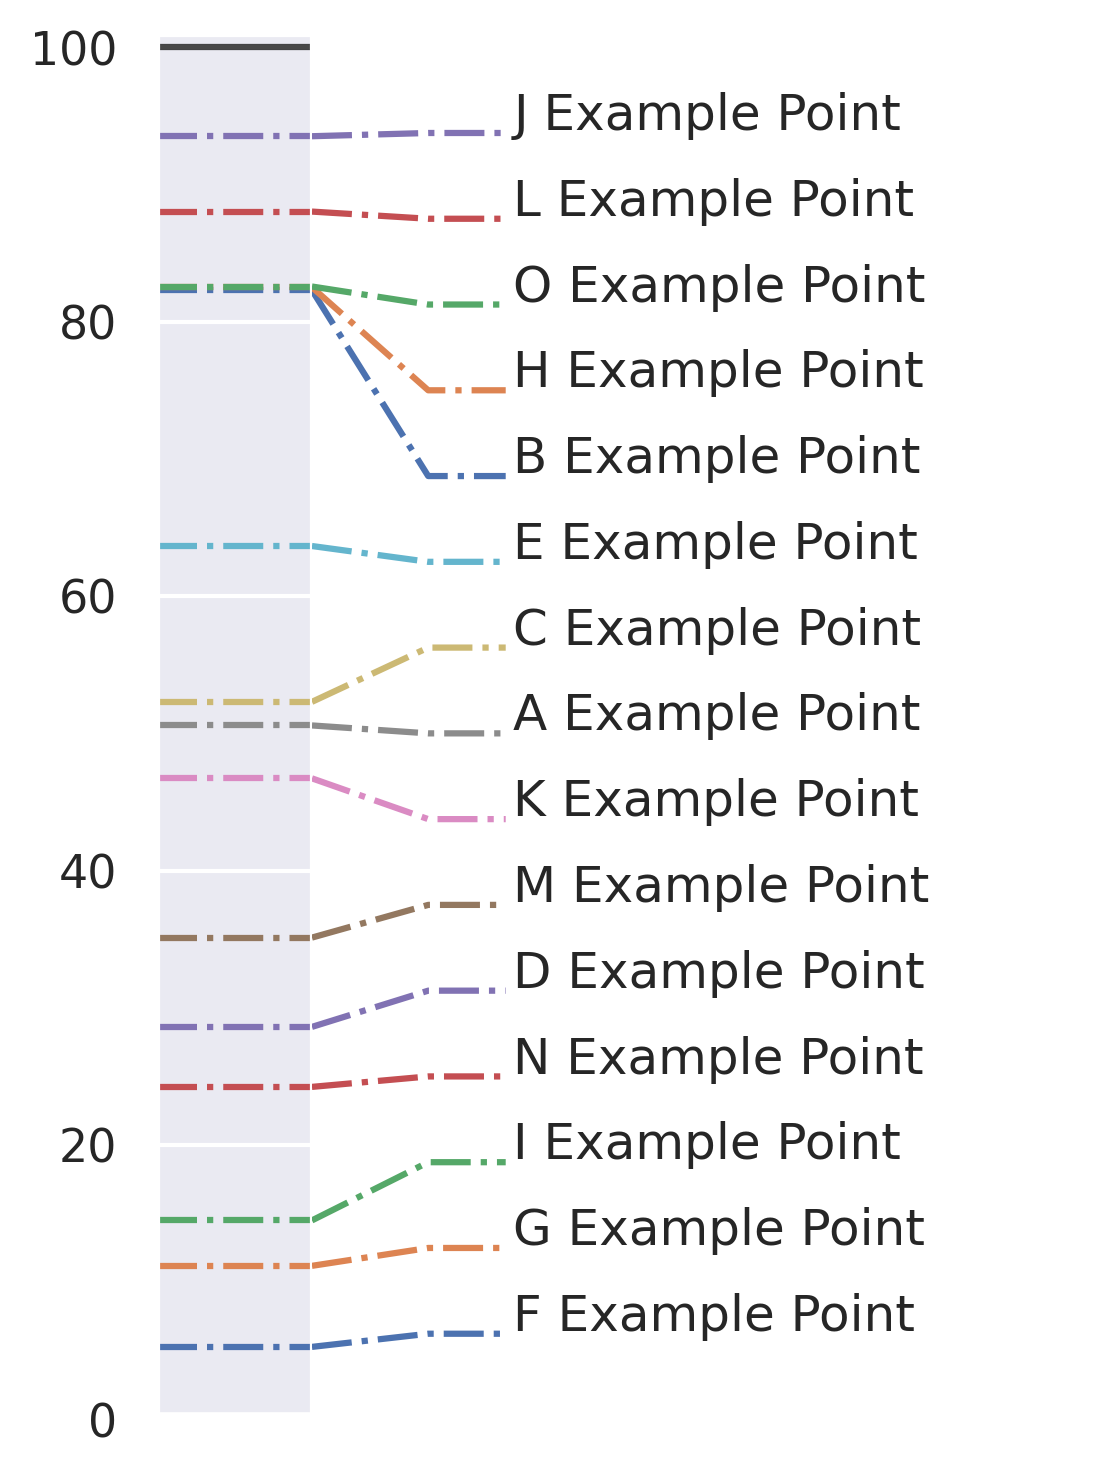

In [4]:
def plot_horizontal(_data, scale=1.0):
    # Data sort
    print(scale)
    _data.sort()
    num_points = len(_data)
    _min, _max  = min([_data[ 0][0],  0.0]), max([_data[-1][0], 1.0*scale])
    #if _min < 0.0:
    #    _min = -1*scale
    linspace = np.linspace(_min, _max, num_points+2)
    
    # Create a figure and axis
    fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(4, 6),
        gridspec_kw={'width_ratios': [1, 5]}, dpi=300)
    plt.subplots_adjust(wspace=0)
    
    # Remove the y-axis and set the y-limits
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_frame_on(False)
    ax1.set_xlim(0, 1)
    ax1.hlines(0,     0, 1, color="k", linestyle="--", alpha=0.001)
    ax1.hlines(scale, 0, 1, color="k", linestyle="--", alpha=0.001)
        
    
    ax2.set_xlim(0, 1)
    ax2.get_xaxis().set_visible(False)
    ax2.hlines(0,     0, 1, color="w", linestyle="-", linewidth=4)
    ax2.hlines(scale, 0, 1, color="k", linestyle="-", alpha=0.8)
    
    # Plot the points on the number line
    for index, (point, label) in enumerate(_data):
        # Default
        linestyle = "-."
        color = None 
        fontweight = "normal"
        fontstyle = "normal"
        
        if "ff" in label:
            linestyle = "-"
        elif "attn h" in label:
            linestyle = ":"
        elif "attn" in label:
            linestyle = "--"
           
        if "random" in label:
            #fontweight = "bold"
            color = "k"
            
        if "rev" in label:
            fontstyle = "italic"
       
        y_label = linspace[index+1] 
        ax1.plot([0, 0.15, 0.25], [point, y_label, y_label], linestyle=linestyle, color=color)
        ax1.text(0.26, y_label-0.005*scale, label, rotation=0, ha='left', va='bottom',
                 fontstyle=fontstyle, fontsize=12, fontweight=fontweight)
        
        ax2.plot([0,1], [point, point], linestyle=linestyle, color=color)
 
    return fig, (ax1, ax2)

def plot_technique_comparison(runs_filtered, scale=1.0, **kwargs):   
    df = pd.DataFrame()
    seen = defaultdict(list)
    for run in runs_filtered:
        r = WandbRunData(run)
        x = 1-normed(r.h, r.cripple, "topk_skip")
        y = 1-normed(r.h, r.focus,   "topk_skip")
        x = np.array([*x, 1])
        y = np.array([*y, 1])
        #area =  1 - calculate_area(x, y)*2
        score = np.array(calculate_max_diff(y, x))
        
        if not "attn_prune_heads" in r.run.config:
            r.run.config["attn_prune_heads"] = False
        if not "attn_prune_heads_mode" in r.run.config:
            r.run.config["attn_prune_heads_mode"] = r.run.config["attn_prune_heads"]
            
        # Get "unique" names
        name = r.run.name.lower()
        name = name.split("gal 1.3b")[-1]
        name = name.split("pythia 1.4b")[-1]
        name = name.split("pc opt 1.3b")[-1]
        name = name.split("opt 1.3b")[-1]
        name = "h".join(name.split("head"))
        name = "".join(name.split(" orig"))
        name = "".join(name.split(" v"))
        
        if "attn h" in name:
            h_type = "attn head " + r.run.config["attn_prune_heads_mode"]
            name = h_type.join( name.split("attn h") )
        #if "rev" in name:
        #    score *= -1
        if r.run.config["attn_prune_heads_mode"] == "median":
            continue
       
        c = r.run.config 
        gen_name = ""
        if not "ff_scoring" in c:
            c["ff_scoring"] = "freq"
        if not "attn_scoring" in c:
            continue
        if c["ff_frac"] > 0 and c["attn_frac"] > 0:
            gen_name += "both"
        elif c["ff_frac"] > 0:
            gen_name += "ff"   + " " + c["ff_scoring"]
        elif c["attn_frac"] > 0:
            gen_name += "attn"
            if c["attn_prune_heads"]:
                gen_name += " head " + c["attn_prune_heads_mode"]     
            gen_name += " " + c["attn_scoring"]
        
        
        #if name in already_seen:
        #    continue
        if name.lower().strip() != gen_name.lower().strip():
            print(f"possibly mislabelled '{gen_name}' (was written as '{name}'). Skipping")
            continue
            
        seen[gen_name].append(score) 
       
    #    plt.plot([0, 1], [1, area], label = r.run.name)
    for k, v in seen.items():
        new_data = { "name": k, "score": list(sorted(v))[-1] }
        df = df_append(df, new_data)
    df = df.sort_values(by="score", ascending=False)
    l = len(df)
   
    data = [ (row["score"]*scale, row["name"]) for _i, row in df.iterrows() ]

    return plot_horizontal(data, scale, **kwargs)
    
scale = 100
points = np.random.random(15) * 100
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
labels = [x + " Example Point" for x in labels]
data = list(zip(points, labels))
data.sort()
print(data)

fig, (ax1, ax2) = plot_horizontal(data, scale)
ax1.set_ylim(-0*scale, 1.01*scale)
ax2.set_ylim(-0*scale, 1.01*scale)
#ax2.text(-1, -0.5, "Code Focus",   ha="left",  va="top")
#ax2.text( 1, -0.5, "Code Cripple", ha="right", va="top")
plt.show()

100


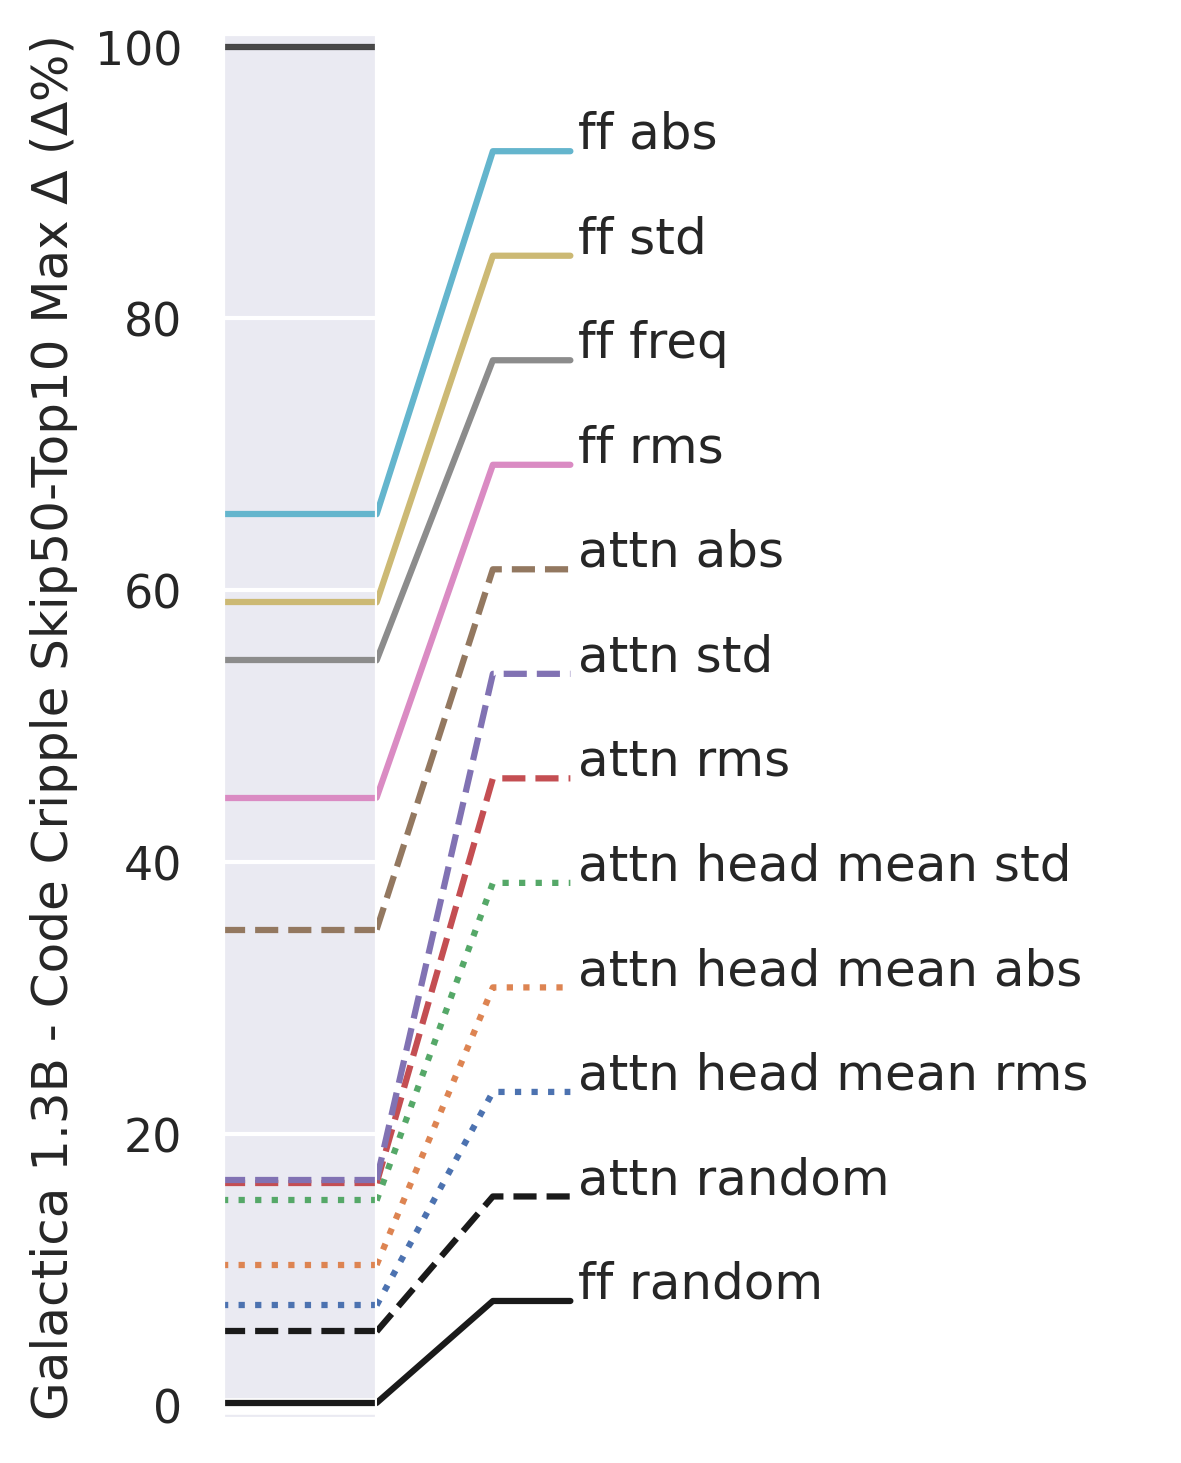

In [5]:
runs_filtered, run_limit = [], None
for run in [*_runs_orig, *_runs_attn]:
    if run_limit and len(runs_filtered) > run_limit:
        break
    if run.state == "crashed":
        continue
    if not run.config["model_size"] == "facebook/galactica-1.3b":
        continue
    if not "_step" in run.summary or run.summary["_step"] < 1:
        continue
    #if not "attn" in run.name:
    #    continue
    if "rev" in run.name:
        continue
    if "svd" in run.name and "attn h" in run.name:
        continue
    if "svd" in run.name:
        continue
    if "sqrt" in run.name:
        continue
    if "both" in run.name:
        continue
    if "few" in run.name:
        continue
    if "L" in run.name:
        continue
    if run.name in [
            "gal 1.3b del bias attn abs",
            "gal 1.3b attn",
            "gal 1.3b both old",
            "gal 1.3b both svd-b",
            "gal 1.3b ff",
        ]:
        continue
    #print(run.name, run.config.items())
    runs_filtered.append(run.url)

scale = 100
fig, (ax1, ax2) = plot_technique_comparison(runs_filtered, scale)
ax1.set_ylim(-0.01*scale, 1.01*scale)
ax2.set_ylim(-0.01*scale, 1.01*scale)
#ax2.text( 1, -0.55, "Code Cripple", ha="right", va="top")
ax2.set_ylabel("Galactica 1.3B - Code Cripple Skip50-Top10 Max ∆ (∆%)")

plt.show()

100


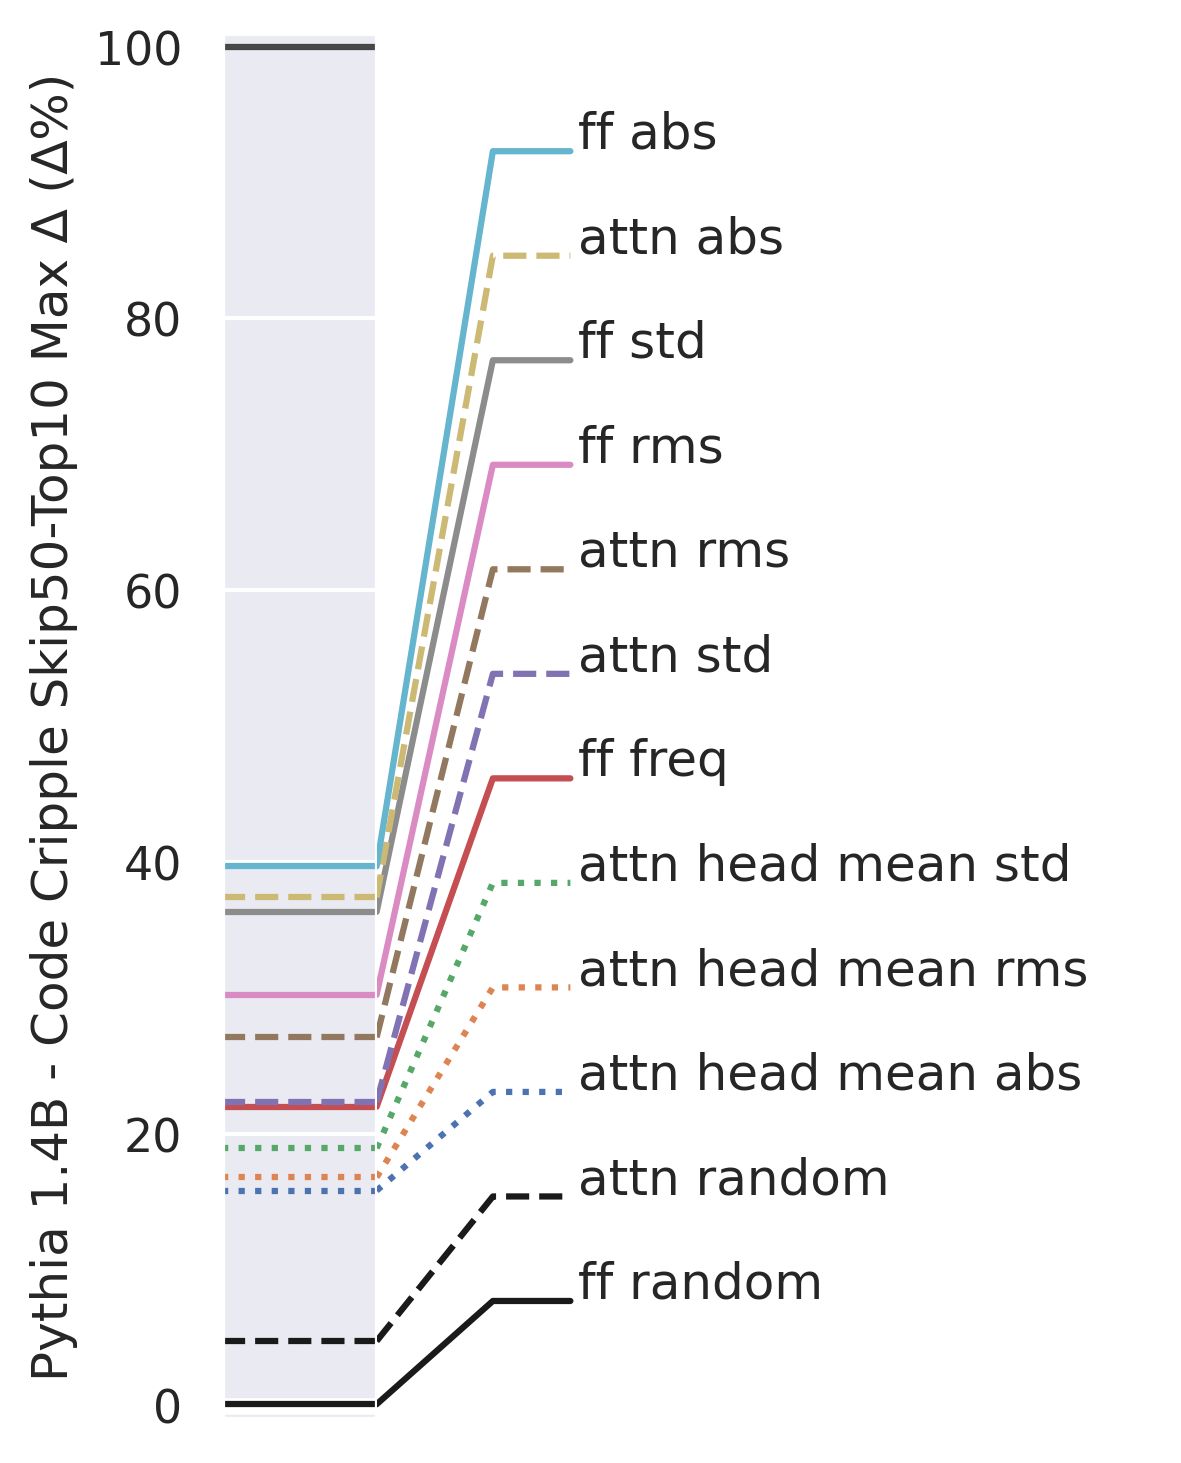

In [6]:
runs_filtered, run_limit = [], None
for run in [*_runs_orig, *_runs_attn]:
    if not run.config["model_size"].lower() == "EleutherAI/pythia-1.4B".lower():
        continue
    if run_limit and len(runs_filtered) > run_limit:
        break
    if not "_step" in run.summary or run.summary["_step"] < 1:
        continue
    #if not "attn" in run.name:
    #    continue
    if "rev" in run.name:
        continue
    if "base" in run.name:
        continue
    if "sqrt" in run.name:
        continue
    #if "attn" in run.name:
    #    continue
    if "L" in run.name:
        continue
    if run.name in [
            "gal 1.3b del bias attn abs",
            "gal 1.3b attn",
            "gal 1.3b both old",
            "gal 1.3b both svd-b",
        ]:
        continue
    #print(run.name, run.config.items())
    runs_filtered.append(run.url)
   
scale = 100 
fig, (ax1, ax2) = plot_technique_comparison(runs_filtered, scale)
ax1.set_ylim(-0.01*scale, 1.01*scale)
ax2.set_ylim(-0.01*scale, 1.01*scale)
ax2.set_ylabel("Pythia 1.4B - Code Cripple Skip50-Top10 Max ∆ (∆%)")
plt.show()

possibly mislabelled 'attn random' (was written as ' ff random'). Skipping
possibly mislabelled 'attn abs' (was written as ' del bias attn abs'). Skipping
100


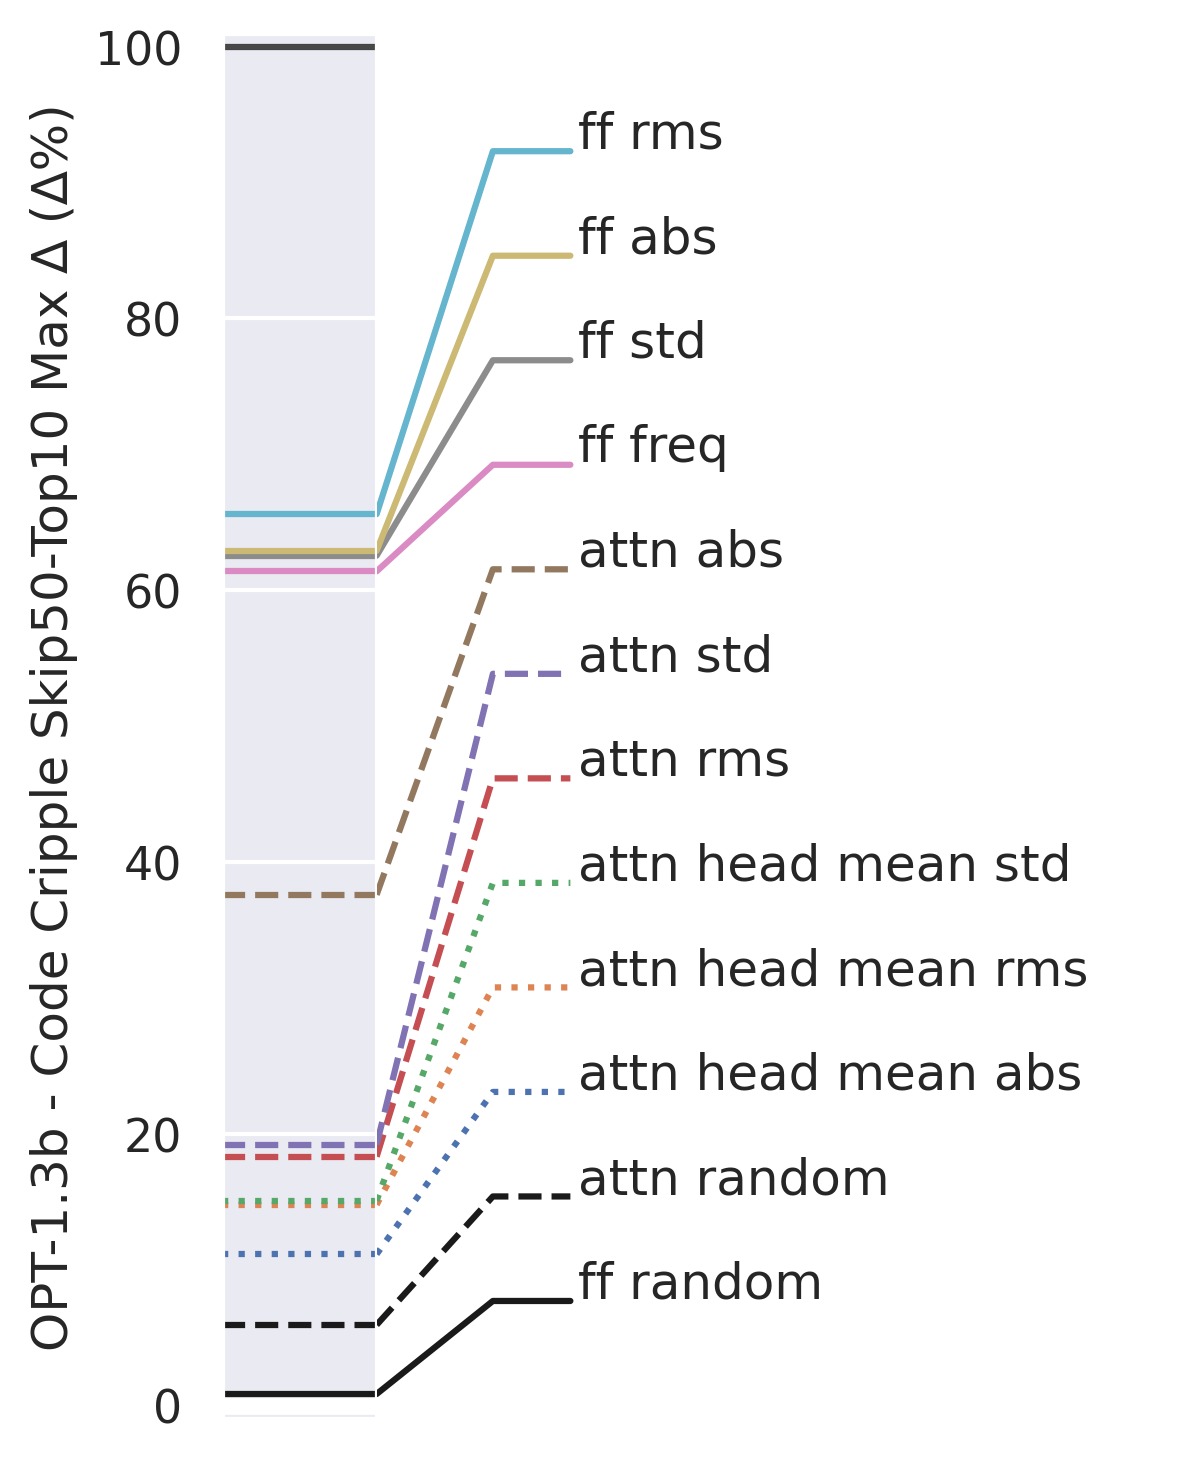

In [7]:

runs_filtered, run_limit = [], None
for run in [*_runs_orig, *_runs_attn]:
    if run_limit and len(runs_filtered) > run_limit:
        break
    if run.state == "crashed":
        continue
    if not "_step" in run.summary or run.summary["_step"] < 1:
        continue
    #if not "pc" in run.name:
    #    continue
    if "rev" in run.name:
        continue
    if " r " in run.name:
        continue
    if "svd" in run.name:
        continue
    if "single" in run.name:
        continue
    if "sqrt" in run.name:
        continue
    #if "svd" in run.name and "attn h" in run.name:
    #    continue
    #if "attn" in run.name and False and \
    #        not ("attn v" in run.name or "attn h" in run.name):
    #    continue
    if not run.config["model_size"] == "facebook/opt-1.3b":
        continue
    if " L" in run.name:
        continue
    if run.name in [
            "gal 1.3b del bias attn abs",
            "gal 1.3b attn",
            "gal 1.3b both old",
            "gal 1.3b both svd-b",
            "gal 1.3b ff",
        ]:
        continue
    #print(run.name, run.config.items())
    runs_filtered.append(run.url)

scale = 100
fig, (ax1, ax2) = plot_technique_comparison(runs_filtered, scale)
ax1.set_ylim(-0.01*scale, 1.01*scale)
ax2.set_ylim(-0.01*scale, 1.01*scale)
ax2.set_ylabel("OPT-1.3b - Code Cripple Skip50-Top10 Max ∆ (∆%)")

plt.show()